blog post should include:

The hook. Why study this collection? What makes it interesting? What research question are you asking?

Methods and metrics. Rather than a formal academic paper treatment ("We used RoBERTa Large with XY parameters..."), I'm expecting a more informal but also descriptive treatment of what models or metrics you used, why you used them, and how they work. Showing off examples for how to compute a metric or what inputs/outputs look like can help here, as well as making diagrams of pieces of the process.

Code snippets. Include code showing key steps in your process (if not the whole process). You don't have to annotate every piece of these in detail, but try to make the code at least somewhat human-friendly. If you're going the Jupyter Notebook route, the code + uploading your data files should be sufficient to reproduce all your results, there may be some slower processing that you prefer to do in advance; just provide a link in the notebook to where any other resources (code, processed versions of data files, etc.) live if you'd prefer to omit those. If you're taking a more prose-based approach, it may make more sense to just include a few key passages that you explain more, but I'd like to see at least three different "interesting" pieces of code: e.g. doing text processing, running models, or computing metrics.

Results. What did you find out? How confident are you of these results? It's a good idea to mix aggregate statistics/findings with specific examples of documents that match (or are outliers of) a particular trend.

# Introduction

Language is complex. Just a few words can convey intense feelings. Some may argue that Twitter tweets are toxic. Is that really the case? Can we train machine learning models to predict the overall sentiment of just a few words in a tweet? 

We are studying a dataset of [Sentiment with 1.6 million tweets with locations](https://www.kaggle.com/datasets/vivekchary/sentiment-with-16-million-tweets-with-locations) found on Kaggle. This dataset consists of 1.6 million tweets from 2009-2017. A majority of these tweets are in English, and they originate from 33 different countries (approximately evenly distributed within the dataset). Each tweet also has a labeled sentiment score, with 0 = negative, 2 = neutral, and 4 = positive.

Our research question consists of two parts: Can we accurately predict the sentiment of a tweet, and does the location of a tweet influence sentiment?

# Methods and Metrics

Before getting into the models, we found that 1.6 million tweets is a lot to parse. We chose to use a sample of this dataset by shuffling (for randomness) and splitting (using 5 parts) to get a smaller dataset of 320,000 tweets. 

We tested three different models on this smaller dataset: a TextBlob Naive Bayes model, a Natural Language ToolKit pre-trained analyzer using VADER, and a Hugging Face Transformer using BERTweet (a RoBERTa model trained on English tweets.)

First, import all functions in `helper_functions.py` by running the code below.



In [1]:
from helper_functions import *

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Below is how we processed our 1.6 million tweets into a managable chunk. Note that we drop a few unnecessary column titles like id, date, flag, and user.

In [2]:
# our downloaded data file is in the folder data/
df = pd.read_csv("data/sentiment140_with_location.csv", names=['target','id','date','flag','user','text', 'location']) 
shuffled = df.sample(frac = 1)
result = np.array_split(shuffled, 5)
split_df = result[0]
split_df = split_df.drop(['id', 'date', 'flag', 'user'], axis=1)
split_df

,target,text,location
1333545,4,@WalkingHorse Good Morning! Thanks for the info,China
985391,4,@fostress i like the word polopoly,Russia
1044360,4,In case you ain't seen the new Dr. Pepper/Dr. ...,Jamaica
613122,0,I dont want to go home,Dominican Republic
40766,0,making PowerP -&gt; last minute,Ecuador
...,...,...,...
202892,0,@DJWebstar are u still mad at me again homie!!...,Nigeria
1103245,4,is happy with my GHWT band set.... just love t...,South Africa
893008,4,"eatin chicharones, talkin 2 vale, thinkin bout...",Indonesia
379744,0,@iam_Casper82 too bad! i'll try to check Anoop...,UK


## Naive Bayes

The first model we used was a Naive Bayes classifier from the Textblob library. The Naive Bayes classifier is a supervised machine learning binary classifier that is based on probability. To use this classifier, we trained the model on a portion of our dataset for a given country. This entailed getting all of the tweets for a country, splitting our dataset in a train test split, which was about 80% train and 20% test. Each example used in training has a "pos" or "neg" label along with the tweet text. After training, we give our model an example from the test set, have it predict the sentiment based on the text, and then we compare the predicted sentiment to the actual sentiment label. We wanted to use the Naive Bayes classifier because we wanted to train our own model and learned about it in class. Note that each classifier we train is based on tweets and sentiment for a given country. Below is the code to train and test the classifier for tweets in the USA.  


In [3]:
# Naive Bayes Classifier
dataset = getLocationTweetsWithSentiment(split_df, "USA")
train = dataset[:int(0.8*len(dataset))] # change this so that its actually a train test split 
test = dataset[int(0.8*len(dataset)):]

cl = NaiveBayesClassifier(train) # train needs tuples of text and pos/neg
correct = 0
for text, sentiment in test:
    pred = cl.classify(text)
    correct += (pred == sentiment)
print(correct/len(test))

0.7417864476386037


From the code above, we can see that the Naive Bayes classifier that is trained on our data got an accuracy of about 74%. 

## NLTK Sentiment Intensity Analyzer

The second model that we used was the [Natural Language ToolKit Sentiment Intensity Analyzer](https://realpython.com/python-nltk-sentiment-analysis/). This model is a pre-trained sentiment analyzer using VADER (Valence Aware Dictionary and sEntiment Reasoner). We chose this model because we wanted to see how accurate a pre-trained sentiment analyzer would be on our dataset. This pre-trained analyzer also works best on small snippets of text from social media, like tweets! To use this model, run the following commands. First, usenload necessary resources for the SIA model: pip to install NLTK in your terminal:
dow

In [3]:
nltk.download([
    "names",
    "stopwords",
    "state_union",
    "twitter_samples",
    "movie_reviews",
    "averaged_perceptron_tagger",
    "vader_lexicon",
    "punkt"])

SyntaxError: invalid syntax (1534887517.py, line 1)

Next, create a SentimentIntensityAnalyzer and find sentiment scores for text. We looped through the tweets in `test` and used the polarity_scores() function to find sentiment scores. 

polarity_scores() returns a dictionary with the keys `pos` (positive score), `neg` (negative score), `neu` (neutral score), and `compound` (compounded score). The scores of `pos`, `neg`, and `neu` add up to 1, and `compound` is a combination of the previous keys such that it equals 0 if the overall score is neutral, <0 if the overall score is negative, and >0 if the overall score is positive.

In the following code snippet, We use the value of `compound` to determine the sentiment score and compare this with the actual labeled score to get the accuracy of this model. Since none of the tweets in our dataset have a neutral score, we change all `neu` predictions by the model to `pos` predictions.

In [2]:
sia = SentimentIntensityAnalyzer()
correct = 0

for text, sentiment in test:
    sia_pred = sia.polarity_scores(text)
    if sia_pred["compound"] < 0:
        pred = "neg"
    else:
        pred = "pos"
    correct += (pred == sentiment)

print("SIA accuracy:", correct/len(test))

[nltk_data] <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED]
[nltk_data]     certificate verify failed: unable to get local issuer
[nltk_data]     certificate (_ssl.c:997)>


False

As you can see, our SIA model performs worse than our Naive Bayes model. 

(reasoning why)

## Hugging Face Transformer

The final model that we looked at was a Hugging Face Transformer built off of [BERTweet](https://github.com/VinAIResearch/BERTweet), a RoBERTa model trained on English tweets. This model is trained with SemEval 2017 corpus, which includes around 40,000 tweets. We chose to use this model because it was built specifically for tweets, and we wanted to see if another pre-trained model would yield similar results as our NLTK SIA model. This model takes in an array of strings to analyze and returns an array of dictionaries of the same length. Each dictionary has exactly two items, a `label` that signifies the sentiment and can equal `POS`, `NEG`, or `NEU`, and a `score` that represents the certainty probability of the label. To use this model, run the following steps:

In [ ]:
specific_model = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

# get array of strings to analyze
data = [text for text, sentiment in test]

# store results of model
results = specific_model(data)

Now we interate through results to find the accuracy of the model. Note that we also convert `NEU` scores to `pos` scores in this model since our dataset does not have any neutral labels.

In [ ]:
correct = 0

for i in range(len(results)):
    pred = results[i]['label'].lower()
    sentiment = test[i][1]
    if pred == 'neu':
        pred = "pos"
    correct += (pred == sentiment)

print("HF accuracy:", correct/len(test))

explanation of hf results + connect to previous model

talk about neutral labels affecting accuracy

## Results

Overall, the results suggest that Naive Bayes is the most accurate model, with roughly 70% accuracy. SIA and hugging face got roughly 60% accuracy. (JULIA INSERT EXPLANATIONS ON THE NEUTRAL AND MISLABELING OF STUFF)

Below we show three different graphs, each representing the average predicted sentiment for four countries' tweets, using the classifiers. The first uses the Naive Bayes classifier and we can compare the actual sentiment to the predicted sentiment for USA, China, Spain, and Canada.

In [3]:
locations = ["USA", "China", "Spain", "Canada"]
data = getSortedLocationScores(split_df)

actual_sentiments = {
    'USA': data["USA"],
    'China': data["China"],
    'Spain': data["Spain"],
    'Canada': data["Canada"]}

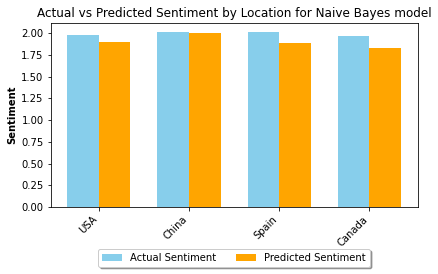

In [4]:
# Naive Bayes
predicted_sentiments_nb = {
    'USA': averageSentimentByLocation("USA", split_df),
    'China': averageSentimentByLocation("China", split_df),
    'Spain': averageSentimentByLocation("Spain", split_df),
    'Canada': averageSentimentByLocation("Canada", split_df)
}

plot_grouped_bar(locations, actual_sentiments, predicted_sentiments_nb, "Naive Bayes")

From the graph above, we see how Naive Bayes compares to the actual average sentiment of the locations from the dataset. It appears that the predicted sentiment lean more towards an average of less than 2, suggesting that more of its predictions are negative rather than positive. However, it is clear that most of the results for the average sentiment for these locations is generally neutral, and is quite clse to the actual average sentiment. Since this model is trained on the dataset, this result is not very surprising.

In [ ]:
# Sentiment Intensity Analyzer
predicted_sentiments_sia = {
    'USA': averageSentimentByLocation_sia("USA", split_df),
    'China': averageSentimentByLocation_sia("China", split_df),
    'Spain': averageSentimentByLocation_sia("Spain", split_df),
    'Canada': averageSentimentByLocation_sia("Canada", split_df)
}

plot_grouped_bar(locations, actual_sentiments, predicted_sentiments_sia, "SIA")

In [ ]:
# Hugging Face Transformer
predicted_sentiments_sia = {
    'USA': averageSentimentByLocation_hf("USA", split_df),
    'China': averageSentimentByLocation_hf("China", split_df),
    'Spain': averageSentimentByLocation_hf("Spain", split_df),
    'Canada': averageSentimentByLocation_hf("Canada", split_df)
}

plot_grouped_bar(locations, actual_sentiments, predicted_sentiments_sia, "Hugging Face")

# Sources

- https://www.kaggle.com/datasets/vivekchary/sentiment-with-16-million-tweets-with-locations
- https://textblob.readthedocs.io/en/dev/api_reference.html#module-textblob.en.sentiments
- https://realpython.com/python-nltk-sentiment-analysis/
- https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis
